## **ANALYSE DU RISQUE DE DEFAUT : CAS DU LOAN CLUB**

### **0. Introduction**

* **Introduction et objectif du projet**

Ce projet a pour objectif de développer un modèle de prédiction du risque de défaut de remboursement (Credit Risk Modeling) pour les demandes de prêt.

L'étude vise à fournir un score de risque individuel (probabilité de défaut) basé sur la modélisation, permettant à l'établissement financier de prendre une décision éclairée (Acceptation/Refus du prêt).

* **Les données**

Les données proviennent de la plateforme de crowdfunding Loan Club et sont contenues dans un fichier CSV. Cet ensemble de données inclut des informations client et le statut final du prêt (remboursé ou en défaut, variable *loan_status*), servant de variable cible pour la modélisation. Nous disposons de 20 000 observations et 26 variables.

* **La méthodologie**

La méthodologie suit un processus structuré, débutant par l'importation et le nettoyage des données, ainsi que la préparation des variables (conversion et encodage). Ensuite, les données sont divisées en ensembles d'entraînement et de test pour l'entraînement d'un modèle de régression logistique. Enfin, la démarche se conclut par l'analyse de la performance (ROC, AUC, matrice de confusion) et la construction d’un score pour la segmentation.


### **1. Importation et inspection des données**

In [1]:
#importation des libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importation de la base de données
df=pd.read_csv("loan_club.csv")

In [3]:
#Nombre d’observations et de variables
df.shape

(20000, 26)

Les données contiennent 20 000 lignes(observations) et 26 colonnes(variables).

In [4]:
#Types de données
df.dtypes

id                            int64
loan_amnt                     int64
term                         object
int_rate                     object
grade                        object
emp_title                    object
emp_length                   object
home_ownership               object
annual_inc                  float64
verification_status          object
loan_status                  object
purpose                      object
zip_code                     object
addr_state                   object
dti                         float64
delinq_2yrs                   int64
inq_last_6mths                int64
pub_rec                       int64
acc_now_delinq                int64
avg_cur_bal                 float64
chargeoff_within_12_mths      int64
delinq_amnt                   int64
num_accts_ever_120_pd         int64
num_actv_bc_tl                int64
num_bc_sats                   int64
pub_rec_bankruptcies          int64
dtype: object

 > Cette sortie présente les types de données initiaux des variables. On note la présence de variables numériques (int64, float64) et de nombreuses variables catégorielles (object).

In [5]:
#Valeurs manquantes
df.isnull().sum()

id                             0
loan_amnt                      0
term                           0
int_rate                       0
grade                          0
emp_title                   1325
emp_length                   946
home_ownership                 0
annual_inc                     0
verification_status            0
loan_status                    0
purpose                        0
zip_code                       0
addr_state                     0
dti                            0
delinq_2yrs                    0
inq_last_6mths                 0
pub_rec                        0
acc_now_delinq                 0
avg_cur_bal                    1
chargeoff_within_12_mths       0
delinq_amnt                    0
num_accts_ever_120_pd          0
num_actv_bc_tl                 0
num_bc_sats                    0
pub_rec_bankruptcies           0
dtype: int64

La quasi-totalité des variables du jeu de données est complète. Toutefois, trois colonnes présentent des valeurs manquantes (NaN) et nécessitent un traitement adapté :

- *emp_title* (1325 NaN) : Le titre de l'emploi est la variable la plus concernée par les valeurs manquantes. En raison de la diversité des intitulés, il sera pertinent d'envisager soit une imputation (par exemple, regroupement ou création d'une catégorie « Inconnu »), soit la suppression de la variable si elle n'apporte pas d'information significative au modèle.

- *emp_length* (946 NaN) : La durée d'emploi est une variable clé pour l'évaluation du risque. Les valeurs manquantes seront remplacées par une modalité spécifique (telle que « Inconnu » ou « Sans emploi ») afin de conserver l'information sans introduire de biais.

- *avg_cur_bal* (1 NaN) : Un seul cas de valeur manquante est observé pour le solde courant moyen. L'observation correspondante sera simplement supprimée, l'impact sur l'analyse étant négligeable.

In [6]:
#Aperçu des premières lignes
df.head(5)

,id,loan_amnt,term,int_rate,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,inq_last_6mths,pub_rec,acc_now_delinq,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,pub_rec_bankruptcies
0,20001,7000,36 months,10.99%,B,BRANCH MANAGER,7 years,MORTGAGE,57000.0,Not Verified,...,1,0,0,8321.0,0,0,0,4,7,0
1,20002,13925,36 months,14.30%,C,Medical biller,< 1 year,RENT,43000.0,Source Verified,...,3,0,0,641.0,0,0,0,5,6,0
2,20003,7000,36 months,10.99%,B,Medical Clerk,7 years,OWN,30000.0,Not Verified,...,0,0,0,837.0,0,0,0,5,6,0
3,20004,9600,36 months,7.90%,A,Bookkeeper,10+ years,MORTGAGE,46000.0,Not Verified,...,0,0,0,14140.0,0,0,0,3,4,0
4,20005,10775,36 months,17.10%,C,Manufacturing Lead,7 years,OWN,75000.0,Source Verified,...,1,0,0,1171.0,0,0,0,1,1,0


### **2. Préparation des données**

Dans cette section, nous allons effectuer un nettoyage approfondi des données, en traitant spécifiquement les colonnes nécessitant une correction ou une transformation. Une attention particulière sera portée au recodage des variables catégorielles afin de garantir la cohérence et la qualité des informations pour la modélisation.

In [7]:
#Nettoyage des valeurs numériques
#TERM
# Extraction des chiffres à gauche de "month" dans les observations de la variable term
df['term'] = df['term'].str.extract(r'(\d+)')
# Affichage du résultat de la transformation
print(df['term'].head(5))

0    36
1    36
2    36
3    36
4    36
Name: term, dtype: object


In [8]:
#INT RATE
# Extraction des chiffres en ignornant le signe % dans la variable "int_rate"
df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)
# Affichage du résultat de la transformation
print(df['int_rate'].head(5))

0    10.99
1    14.30
2    10.99
3     7.90
4    17.10
Name: int_rate, dtype: float64


In [9]:
# Encodage des variables catégorielles et détermination des modalités de référence
#EMP LENGTH
# Recodage de la variable emp_length(niveau d'experience)
#Regroupement des nouvelles modalités dans le dictionnaire pour les appliquer après
emp_length_rec = {
    "< 1 year": "jeune_diplome",
    "1 year": "jeune_diplome",
    "2 years": "junior",
    "3 years": "junior",
    "4 years": "junior",
    "5 years": "confirme",
    "6 years": "confirme",
    "7 years": "confirme",
    "8 years": "confirme",
    "9 years": "confirme",
    "10+ years": "senior"
}

# Application des modifications
df['emp_length'] = df['emp_length'].replace(emp_length_rec).fillna('inconnu') 
# les valeurs manquantes seront remplacées par "inconnu"

# Affichage des catégories
df['emp_length'].unique()

array(['confirme', 'jeune_diplome', 'senior', 'inconnu', 'junior'],
      dtype=object)

In [10]:
#HOME OWNSHIP
home_ownership_rec = {
    "RENT": "locataire",
    "OWN": "proprietaire",
    "MORTGAGE": "hypotheque",
}

# Application des modifications
df['home_ownership'] = df['home_ownership'].replace(home_ownership_rec)

#Affichage des modalités
df['home_ownership'].unique()

array(['hypotheque', 'locataire', 'proprietaire'], dtype=object)

In [11]:
#LOAN STATUS
loan_status_rec = {
    "Charged Off": 1,
    "Fully Paid": 0,
}

# Application des modifications
df['loan_status'] = df['loan_status'].replace(loan_status_rec).astype('int64')

C:\Users\marln\AppData\Local\Temp\ipykernel_12272\2183009751.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['loan_status'] = df['loan_status'].replace(loan_status_rec).astype('int64')


In [12]:
#PURPOSE
purpose_rec = {
    "car": "depenses_divers",
    "credit_card": "carte_credit",
    "debt_consolidation": "consolidation_dette",
    "home_improvement": "habitat",
    "house": "habitat",
    "major_purchase": "depenses_divers",
    "medical": "depenses_divers",
    "moving": "habitat",
    "other": "depenses_divers",
    "renewable_energy": "habitat",
    "small_business": "petit_commerce",
    "vacation": "depenses_divers",
    "wedding": "depenses_divers"
}

# Application des modifications
df['purpose'] = df['purpose'].replace(purpose_rec)

# Affichage des modalités
df['purpose'].unique()

array(['consolidation_dette', 'carte_credit', 'habitat',
       'depenses_divers', 'petit_commerce'], dtype=object)

In [13]:
# Vérification du type de variables après transformation
df.dtypes

id                            int64
loan_amnt                     int64
term                         object
int_rate                    float64
grade                        object
emp_title                    object
emp_length                   object
home_ownership               object
annual_inc                  float64
verification_status          object
loan_status                   int64
purpose                      object
zip_code                     object
addr_state                   object
dti                         float64
delinq_2yrs                   int64
inq_last_6mths                int64
pub_rec                       int64
acc_now_delinq                int64
avg_cur_bal                 float64
chargeoff_within_12_mths      int64
delinq_amnt                   int64
num_accts_ever_120_pd         int64
num_actv_bc_tl                int64
num_bc_sats                   int64
pub_rec_bankruptcies          int64
dtype: object

In [14]:
# Affichage des valeurs manquantes
df.isnull().sum()

id                             0
loan_amnt                      0
term                           0
int_rate                       0
grade                          0
emp_title                   1325
emp_length                     0
home_ownership                 0
annual_inc                     0
verification_status            0
loan_status                    0
purpose                        0
zip_code                       0
addr_state                     0
dti                            0
delinq_2yrs                    0
inq_last_6mths                 0
pub_rec                        0
acc_now_delinq                 0
avg_cur_bal                    1
chargeoff_within_12_mths       0
delinq_amnt                    0
num_accts_ever_120_pd          0
num_actv_bc_tl                 0
num_bc_sats                    0
pub_rec_bankruptcies           0
dtype: int64

##### Gestion des valeurs manquantes

- La variable *emp_title*, jugée peu pertinente pour l’analyse, sera supprimée afin de simplifier le jeu de données.
- Concernant *avg_cur_bal*, une seule observation présente une valeur manquante ; cette ligne sera retirée sans impact significatif sur l’analyse.

In [15]:
# Suppression les lignes avec les valeurs manquantes dans la variable "emp_title"
df = df[df['emp_title'].notna()]
# Suppression de la ligne où la variable "avg_cur_bal" est vide
df = df[df['avg_cur_bal'].notna()]

# Vérification l'effectif des valeurs manquantes 
df.isnull().sum()

id                          0
loan_amnt                   0
term                        0
int_rate                    0
grade                       0
emp_title                   0
emp_length                  0
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
purpose                     0
zip_code                    0
addr_state                  0
dti                         0
delinq_2yrs                 0
inq_last_6mths              0
pub_rec                     0
acc_now_delinq              0
avg_cur_bal                 0
chargeoff_within_12_mths    0
delinq_amnt                 0
num_accts_ever_120_pd       0
num_actv_bc_tl              0
num_bc_sats                 0
pub_rec_bankruptcies        0
dtype: int64

### **3. Analyse exploratoire**

#### 3.1. Statistiques descriptives

> La sortie ci-dessous présente les principales statistiques descriptives (moyenne, écart-type, min, max, quartiles) pour chaque variable numérique du jeu de données. Cela permet d'obtenir une vue d'ensemble sur la distribution, la dispersion et les éventuelles valeurs extrêmes (outliers) des variables, facilitant ainsi la détection d'anomalies ou de besoins de transformation avant la modélisation.

In [16]:
df.describe().round(2)

,id,loan_amnt,int_rate,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,acc_now_delinq,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,pub_rec_bankruptcies
count,18674.00,18674.00,18674.00,18674.00,18674.00,18674.00,18674.0,18674.00,18674.00,18674.00,18674.00,18674.00,18674.00,18674.00,18674.00,18674.00,18674.00
mean,29983.73,14724.45,14.46,73430.71,0.15,17.40,0.3,0.78,0.13,0.01,13909.14,0.01,13.70,0.36,3.72,4.59,0.11
std,5775.56,8046.71,4.58,45905.61,0.36,7.50,0.8,1.03,0.54,0.09,15241.18,0.09,714.36,1.01,2.02,2.42,0.33
min,20001.00,1000.00,6.00,9518.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,24973.25,8800.00,10.99,47000.00,0.00,11.73,0.0,0.00,0.00,0.00,3235.50,0.00,0.00,0.00,2.00,3.00,0.00
50%,29980.50,13000.00,14.30,65000.00,0.00,17.10,0.0,0.00,0.00,0.00,8435.50,0.00,0.00,0.00,3.00,4.00,0.00
75%,34978.75,20000.00,17.76,89000.00,0.00,22.91,0.0,1.00,0.00,0.00,19972.00,0.00,0.00,0.00,5.00,6.00,0.00
max,40000.00,35000.00,26.06,2000000.00,1.00,34.99,18.0,6.00,49.00,5.00,218986.00,3.00,53760.00,19.00,21.00,25.00,8.00


1. Variables clés de solvabilité et endettement

- *loan_status* (Variable cible) : La moyenne est de 0.15, indiquant que le taux de défaut est d'environ 15% dans l'échantillon. La classe est déséquilibrée (85% de prêts remboursés), un point à considérer pour la modélisation (techniques de rééchantillonnage ou ajustement des poids de classe).

- *annual_inc* (Revenu annuel) : Le revenu annuel moyen est de 73 430 €. L'écart-type très élevé (45 905 €) et la valeur maximale de 2 000 000 € indiquent la présence de valeurs aberrantes (outliers) extrêmes dans le haut de la distribution.

- *dti* (Debt-to-Income) : Le ratio moyen est de 17.40. Le maximum de 34.99 est très proche du seuil maximal de 35-40% souvent utilisé dans le secteur, mais semble plausible pour des cas extrêmes. Sa distribution inter-quartile (11.73 à 22.91)

2. Caractéristiques du prêt

- *loan_amnt* (Montant du prêt) : Le montant moyen est de 14 724 €. L'étendue va de 1 000 € à 35 000 €. La distribution est assez large (écart-type de 8 046 €), mais les quartiles montrent une concentration des prêts entre 8 800 € et 20 000 €.

- *int_rate* (Taux d'intérêt) : Le taux moyen est de 14.46% avec une dispersion modérée (écart-type 4.58). La fourchette de 6.00% à 26.06% reflète bien le spectre de risque, généralement les taux les plus élevés étant associés aux emprunteurs les plus risqués.

3. Indicateurs de risque passé (Historique de crédit)

Les variables liées aux défauts passés (delinq_2yrs, pub_rec, chargeoff_within_12_mths, num_accts_ever_120_pd, acc_now_delinq) présentent des moyennes très faibles (proches de zéro).

Par exemple, delinq_2yrs a une moyenne de 0.3, et pub_rec_bankruptcies une moyenne de 0.11. Ceci indique que la majorité des emprunteurs n'ont aucun incident de crédit récent ou historique.

Cependant, les valeurs maximales (ex: delinq_2yrs à 18, pub_rec à 49, delinq_amnt à 53 760) confirment l'existence de quelques cas d'emprunteurs avec un historique de crédit très sévèrement dégradé.

#### 1. Visualisation de la variable cible (loan_status)

La variable loan_status est binaire : elle indique si le prêt a été remboursé ou est en défaut.

In [32]:
status_counts = df['loan_status'].value_counts()
status_pourcentages = df['loan_status'].value_counts(normalize=True) * 100

# Créer un tableau récapitulatif
status_recap = pd.DataFrame({
    'Effectif': status_counts,
    'Pourcentage': status_pourcentages.round(2)
})

print("==== Analyse de Fréquence de la Variable Cible (loan_status) ====")
print(status_recap)

==== Analyse de Fréquence de la Variable Cible (loan_status) ====
             Effectif  Pourcentage
loan_status                       
0               15804        84.63
1                2870        15.37


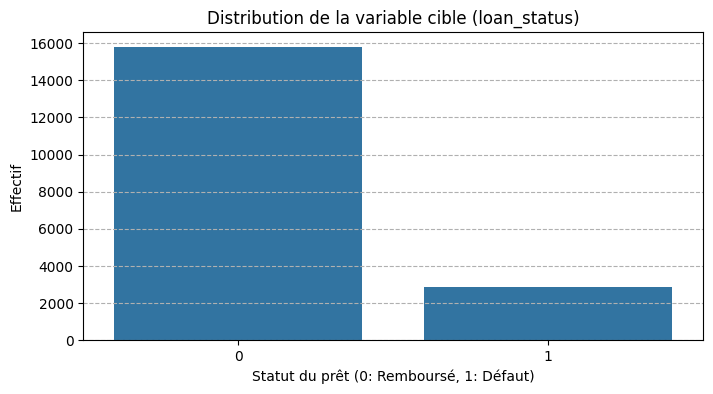

In [33]:
plt.figure(figsize=(8, 4))
sns.countplot(x='loan_status', data=df, order=df['loan_status'].value_counts().index)
plt.title('Distribution de la variable cible (loan_status)')
plt.xlabel('Statut du prêt (0: Remboursé, 1: Défaut)')
plt.ylabel('Effectif')
plt.grid(axis='y', linestyle='--')
plt.show()

Les données sont fortement déséquilibrées (85% de Remboursé vs 15% de Defaut).

Impact sur la modélisation : Ce déséquilibre est une préoccupation majeure. Si le modèle prédit toujours la classe majoritaire (Remboursé), il atteindra une précision de 85%, ce qui est trompeur.

#### 2. Visualisation du taux d'interet

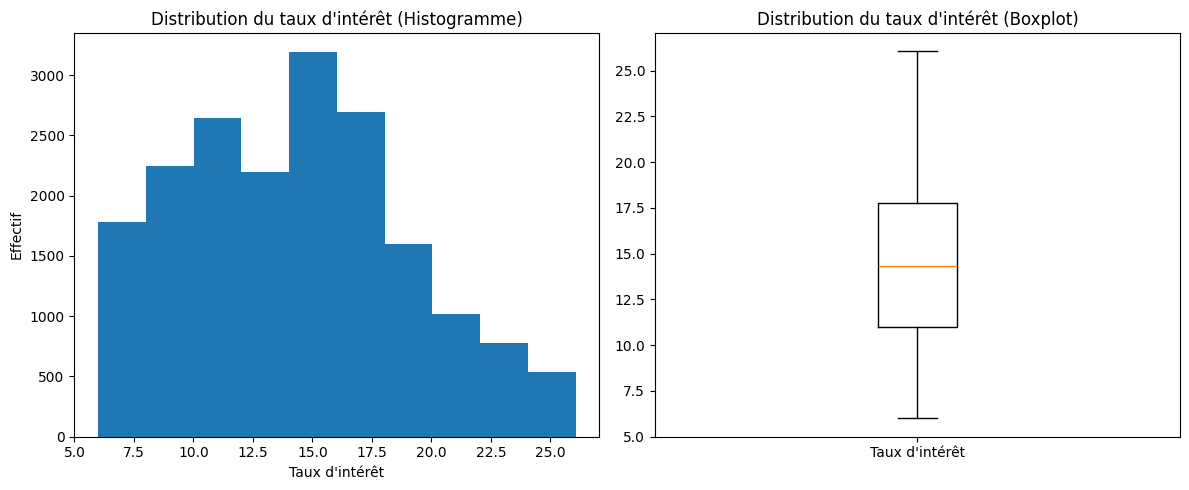

In [19]:
# Création de la figure (fig) et des deux sous-graphiques (axes)
# (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Histogramme 
axes[0].hist(df["int_rate"])
axes[0].set_title("Distribution du taux d'intérêt (Histogramme)" )
axes[0].set_xlabel("Taux d'intérêt")
axes[0].set_ylabel("Effectif")

# 2. Boxplot
axes[1].boxplot(df["int_rate"])
axes[1].set_title("Distribution du taux d'intérêt (Boxplot)")
axes[1].set_xticklabels(['Taux d\'intérêt']) # Nomme l'axe des x pour le boxplot

# Ajustement de l'espace entre les sous-graphiques
plt.tight_layout()

# Affichage de la figure
plt.show()

* Mode et Médiane : L'histogramme montre une forte concentration des prêts dans la classe 12.5% à 15%, qui représente le taux modal. Le boxplot confirme une médiane autour de 14.5%.

* Implication opérationnelle : La majorité des clients du portefeuille se situe dans la catégorie de risque moyen-élevé. C'est sur cette plage que notre modèle devra être le plus précis.

* 50% des observations se trouvent entre $\approx 11\%$ ($Q_1$) et $\approx 17.8\%$ ($Q_3$).L'absence de points isolés sur le boxplot et la continuité de la distribution sur l'histogramme (de 6% à 26%) confirment que la variable est robuste. Aucun traitement d'outlier n'est nécessaire pour cette variable.

#### 3. Durée du prêt

Ici, il est question de calculer la répartition des prêts entre les différentes durées.

In [22]:
# Compter les occurrences de chaque catégorie
term_counts = df['term'].value_counts()

# Calculer les pourcentages
term_pourcentages = df['term'].value_counts(normalize=True) * 100

# Créer un tableau récapitulatif
term_recap = pd.DataFrame({
    'Effectif': term_counts,
    'Pourcentage': term_pourcentages.round(2)
})

print("==== Analyse de fréquence de la durée du prêt 'term' ====")
print(term_recap)

==== Analyse de fréquence de la durée du prêt 'term' ====
      Effectif  Pourcentage
term                       
36       13372        71.61
60        5302        28.39


La visualisation permet de confirmer rapidement l'équilibre ou le déséquilibre entre les durées de prêt.

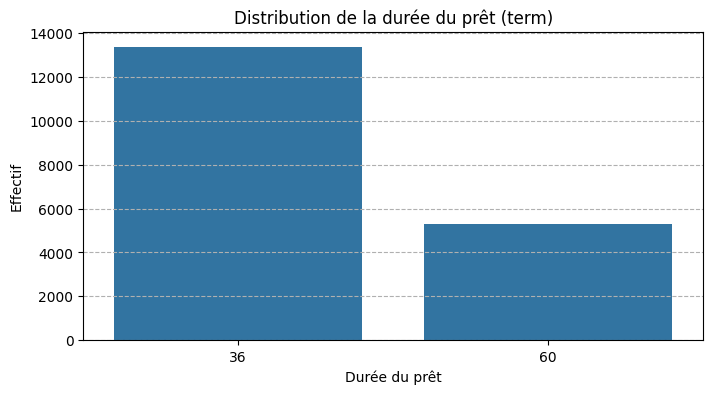

In [28]:
plt.figure(figsize=(8, 4))
sns.countplot(x='term', data=df, order=df['term'].value_counts().index)

plt.title('Distribution de la durée du prêt (term)')
plt.xlabel('Durée du prêt')
plt.ylabel('Effectif')
plt.grid(axis='y', linestyle='--')
plt.show()

Le tableau de fréquences et le graphique à barres révèlent une répartition claire des durées des prêts.
La grande majorité des prêts ont une durée courte de 36 mois, représentant 71.61% de l'échantillon (13 372 observations) tandis que les prêts d'une durée plus longue de 60 mois représentent une part de 28.39% de l'échantillon (5 302 observations).

Les prêts à 36 mois sont généralement considéré comme un profil de risque plus faible car l'exposition au défaut est réduite dans le temps. Néanmoins, près d'un tiers du portefeuille (28.39%) est constitué de prêts à 60 mois. Ces prêts sont intrinsèquement plus risqués (le risque d'événements financiers négatifs augmentant avec la durée).

#### 3.3. Analyse bivariée

##### 1. Montant du prêt et le statut de défaut

L'analyse bivariée entre le montant du prêt (loan_amnt) et le statut de défaut (loan_status) permet d'évaluer si les montants de prêts sont significativement plus élevés pour les clients en défaut. On va nous servir du Test T de Student qui permet de voir si les moyennes des deux groupes sont statistiquement différentes.

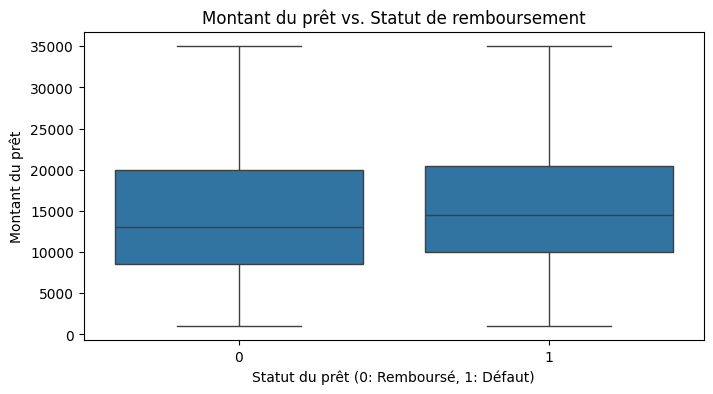


==== Test T de Student pour loan_amnt ====
Statistique T : -6.63
P-value : 0.00000


In [36]:
from scipy.stats import ttest_ind

# Analyse graphique : Boxplots
plt.figure(figsize=(8, 4))
sns.boxplot(x='loan_status', y='loan_amnt', data=df)
plt.title('Montant du prêt vs. Statut de remboursement')
plt.xlabel('Statut du prêt (0: Remboursé, 1: Défaut)')
plt.ylabel('Montant du prêt')
plt.show()

# Test Statistique : Test T de Student
# Filtrer les montants par statut
rembourses = df[df['loan_status'] == 0]['loan_amnt'].dropna()
defaut = df[df['loan_status'] == 1]['loan_amnt'].dropna()

# Le Test T de Student permet de voir si les moyennes des deux groupes sont statistiquement différentes
statistic, p_value = ttest_ind(rembourses, defaut, equal_var=False)

print(f"\n==== Test T de Student pour loan_amnt ====")
print(f"Statistique T : {statistic:.2f}")
print(f"P-value : {p_value:.5f}")

**Interprétation :** 

* La médiane du montant du prêt est légèrement plus élevée pour le groupe Défaut (1) que pour le groupe Remboursé (0).La fourchette inter-quartile ($Q_1$ à $Q_3$) pour les défauts se situe aussi légèrement plus haut, indiquant que le cœur des prêts en défaut tend à être d'un montant supérieur aux prêts remboursés.L'étendue totale (des moustaches) est la même, s'étendant du minimum ($1\ 000$) au maximum ($35\ 000$), ce qui est attendu.

* La p-value est largement inférieure au seuil de signification standard $\mathbf{\alpha = 0.05}$. Nous rejetons l'hypothèse nule ($H_0$), ce qui signifie qu'il existe une différence statistiquement très significative entre le montant moyen du prêt accordé aux emprunteurs qui ont remboursé et ceux qui ont fait défaut.

* Conclusion : Un montant de prêt plus élevé représente une charge de dette plus lourde qui augmente la sensibilité de l'emprunteur aux chocs financiers et, par conséquent, son risque de défaut.

##### 2. Ratio dti et le statut de défaut

Le ratio Dette/Revenu est un indicateur de solvabilité critique.

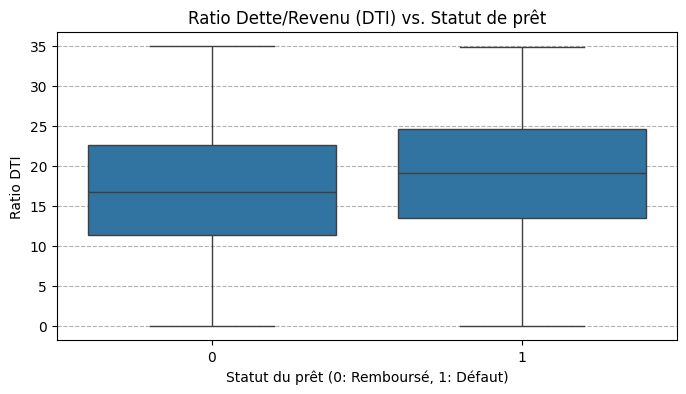


==== Test T de Student pour DTI ====
DTI moyen des Remboursés (0) : 17.11
DTI moyen des Défauts (1) : 19.01
-----------------------------------
Statistique T : -12.59
P-value : 0.00000


In [39]:
# Visualisation : Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x='loan_status', y='dti', data=df)
plt.title('Ratio Dette/Revenu (DTI) vs. Statut de prêt')
plt.xlabel('Statut du prêt (0: Remboursé, 1: Défaut)')
plt.ylabel('Ratio DTI')
plt.grid(axis='y', linestyle='--')
plt.show() # 

# Test Statistique : Test T de Student
rembourses_dti = df[df['loan_status'] == 0]['dti'].dropna()
defaut_dti = df[df['loan_status'] == 1]['dti'].dropna()

statistic_dti, p_value_dti = ttest_ind(rembourses_dti, defaut_dti, equal_var=False)

print(f"\n==== Test T de Student pour DTI ====")
print(f"DTI moyen des Remboursés (0) : {rembourses_dti.mean():.2f}")
print(f"DTI moyen des Défauts (1) : {defaut_dti.mean():.2f}")
print("-" * 35)
print(f"Statistique T : {statistic_dti:.2f}")
print(f"P-value : {p_value_dti:.5f}")

**Interprétation :**

- Si le DTI moyen des Défauts est plus élevé, cela confirme que le dti est un excellent prédicteur de défaut, car une dette plus lourde par rapport au revenu augmente le risque.

- La p-value est très faible ($\approx 0.000$), on conclue que le dti est significativement différent entre les deux groupes. 


##### 3. Revenu annuel et le statut du prêt

Le revenu annuel est l'indicateur de capacité de remboursement. Cette variable ayant des valeurs abbérantes (outliers), il sera preferable de se baser sur la médiane plutot que la moyenne. En effet, la moyenne est plus sensible aux valeurs extremes. On utilisera également le Test de Mann-Whitney U (équivalent non paramétrique du Test T).

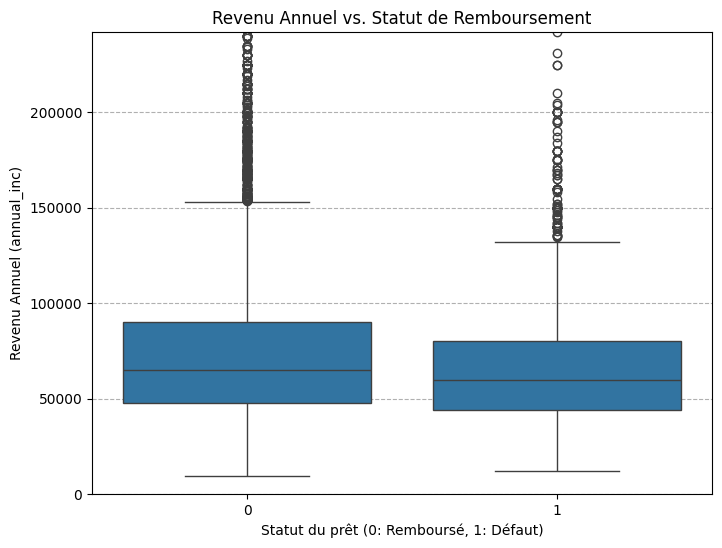


==== Test de Mann-Whitney U pour annual_inc ====
Médiane des Remboursés (0) : 65000.00
Médiane des Défauts (1) : 60000.00
---------------------------------------------
Statistique U : 25726472.00
P-value : 0.00000


In [40]:
from scipy.stats import mannwhitneyu
# Visualisation : Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='loan_status', y='annual_inc', data=df)
plt.title('Revenu Annuel vs. Statut de Remboursement')
plt.xlabel('Statut du prêt (0: Remboursé, 1: Défaut)')
plt.ylabel('Revenu Annuel (annual_inc)')
plt.ylim(0, df['annual_inc'].quantile(0.99) * 1.1) # Limite l'affichage pour la lisibilité
plt.grid(axis='y', linestyle='--')
plt.show() # 

# Test Statistique : Test de Mann-Whitney U (plus robuste face aux outliers et non-normalité)
rembourses_inc = df[df['loan_status'] == 0]['annual_inc'].dropna()
defaut_inc = df[df['loan_status'] == 1]['annual_inc'].dropna()

statistic_u, p_value_u = mannwhitneyu(rembourses_inc, defaut_inc, alternative='two-sided')

print(f"\n==== Test de Mann-Whitney U pour annual_inc ====")
print(f"Médiane des Remboursés (0) : {rembourses_inc.median():.2f}")
print(f"Médiane des Défauts (1) : {defaut_inc.median():.2f}")
print("-" * 45)
print(f"Statistique U : {statistic_u:.2f}")
print(f"P-value : {p_value_u:.5f}")

**Interprétation :**

- Différence des médianes : La médiane du groupe Défaut (1) est visiblement inférieure à celle du groupe Remboursé (0).  Les clients en défaut ont une médiane de revenu 5 000 inférieure aux clients qui remboursent (60 000 vs 65 000). Cela soutient la logique de risque : un revenu plus faible réduit la capacité de l'emprunteur à faire face aux paiements et augmente la probabilité de défaut (PD).

- Quartiles : La boîte (intervalle inter-quartile) du groupe Défaut se situe également plus bas que celle du groupe Remboursé, confirmant que le gros des emprunteurs en défaut a un revenu plus faible.

- Outliers/Valeurs abbérantes: La présence de nombreux outliers (revenus très élevés) dans les deux groupes confirme la nécessité d'appliquer un plafonnement (Winsorization) à cette variable pour stabiliser les coefficients du modèle.

- La p-value est largement inférieure au seuil de $\alpha = 0.05$. Nous rejetons l'hypothèse nulle : la médiane du revenu annuel est statistiquement différente entre les clients en défaut et ceux qui remboursent.

##### 4. Durée du prêt et statut du prêt

Ayant déjà vue la distribution de la durée du prêt, quantifions maintenant le risque associé à chaque durée.

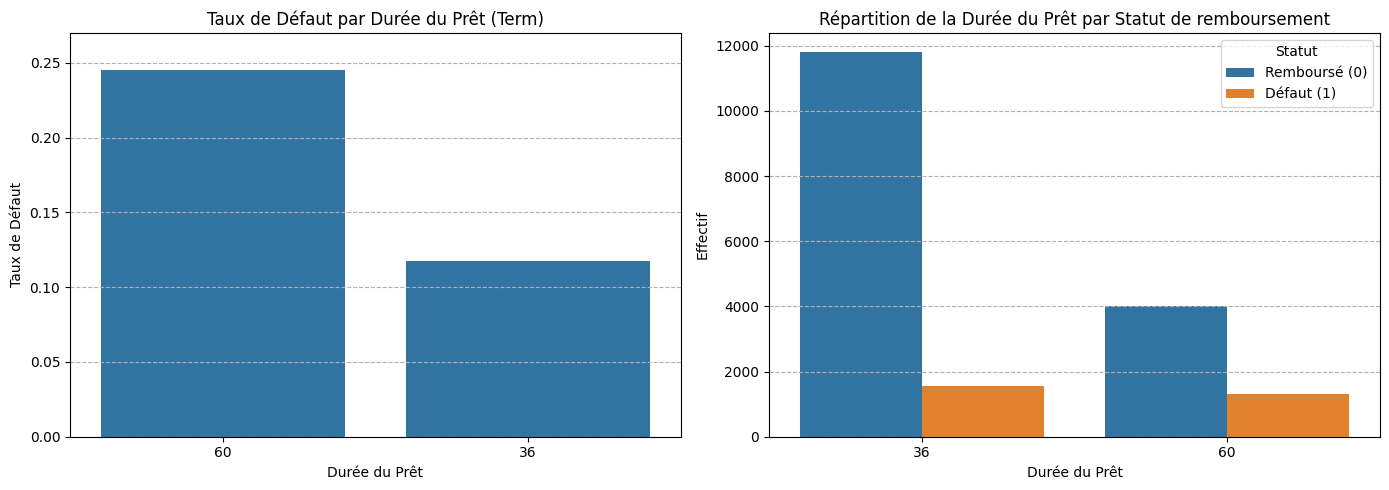


==== Test du Chi-Carré pour term ====
Taux de défaut (36 mois) : 0.1173
Taux de défaut (60 mois) : 0.2456
-----------------------------------
Statistique Chi2 : 479.55
P-value : 0.00000


In [ ]:
from scipy.stats import chi2_contingency

# Calcul du taux de défaut (moyenne de loan_status) par durée
defaut_rate_term = df.groupby('term')['loan_status'].mean().sort_values(ascending=False)

# Création de la Figure Combinée (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 (Taux de Défaut par Durée)
sns.barplot(x=defaut_rate_term.index, y=defaut_rate_term.values, ax=axes[0])
axes[0].set_title("Taux de Défaut par Durée du Prêt (Term)")
axes[0].set_xlabel('Durée du Prêt')
axes[0].set_ylabel('Taux de Défaut')
axes[0].grid(axis='y', linestyle='--')
axes[0].set_ylim(0, max(defaut_rate_term.values) * 1.1)

# Graphique 2 (Répartition de la cible)
# Utilisez pd.crosstab pour obtenir les effectifs pour une visualisation précise
contingency_table_term = pd.crosstab(df['term'], df['loan_status']).reset_index()
contingency_table_term.columns = ['term', 'Remboursé (0)', 'Défaut (1)']
contingency_melted = contingency_table_term.melt('term', var_name='Statut', value_name='Effectif')

sns.barplot(x='term', y='Effectif', hue='Statut', data=contingency_melted, ax=axes[1])
axes[1].set_title(f"Répartition de la Durée du prêt par Statut de remboursement")
axes[1].set_xlabel('Durée du Prêt')
axes[1].set_ylabel('Effectif')
axes[1].grid(axis='y', linestyle='--')
axes[1].legend(title='Statut')

# Ajuster la mise en page
plt.tight_layout()
plt.show()

# Test Statistique
# Le tableau de contingence est déjà calculé ci-dessus
chi2_term, p_value_term, dof_term, expected_term = chi2_contingency(pd.crosstab(df['term'], df['loan_status']))

print(f"\n==== Test du Chi-Carré pour term ====")
# Les taux doivent être calculés à nouveau car defaut_rate_term.loc['36'] est un accès de série, pas une sortie print
print(f"Taux de défaut (36 mois) : {df.groupby('term')['loan_status'].mean().loc['36']:.4f}")
print(f"Taux de défaut (60 mois) : {df.groupby('term')['loan_status'].mean().loc['60']:.4f}")
print("-" * 35)
print(f"Statistique Chi2 : {chi2_term:.2f}")
print(f"P-value : {p_value_term:.5f}")

##### 5. Niveau de l'expérience professionnelle et le statut de défaut

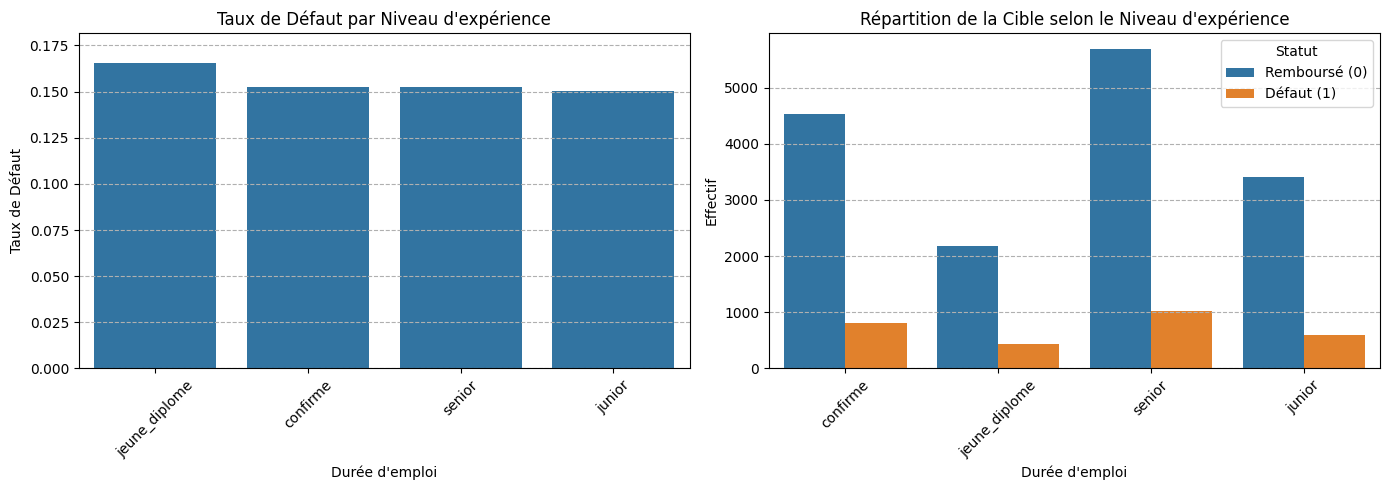


--- Test du Chi-Carré pour emp_length ---
Statistique Chi2 : 3.25
P-value : 0.35397


In [ ]:
# Calcul du taux de défaut (moyenne de loan_status) par durée d'emploi
defaut_rate_emp = df.groupby('emp_length')['loan_status'].mean(). sort_values(ascending=False)

# Création de la Figure Combinée (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) # Ajuster la taille pour le côte à côte

# Graphique 1 (Taux de Défaut par catégorie)
sns.barplot(x=defaut_rate_emp.index, y=defaut_rate_emp.values, ax=axes[0])
axes[0].set_title("Taux de Défaut par Niveau d'expérience")
axes[0].set_xlabel("Durée d'emploi")
axes[0].set_ylabel('Taux de Défaut')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--')
axes[0].set_ylim(0, max(defaut_rate_emp.values) * 1.1)

# Graphique 2 (Répartition de la cible)
sns.countplot(x=df['emp_length'], hue="loan_status", data=df, ax=axes[1])
axes[1].set_title(f"Répartition de la cible selon le Niveau d'expérience")
axes[1].set_xlabel("Durée d'emploi")
axes[1].set_ylabel('Effectif')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Statut', labels=['Remboursé (0)', 'Défaut (1)'])
axes[1].grid(axis='y', linestyle='--')

# Ajuster la mise en page
plt.tight_layout()
plt.show()

# Test Statistique
contingency_table_emp = pd.crosstab(df['emp_length'], df['loan_status'])
chi2_emp, p_value_emp, dof_emp, expected_emp = chi2_contingency(contingency_table_emp)

print(f"\n==== Test du Chi-Carré pour emp_length ====")
print(f"Statistique Chi2 : {chi2_emp:.2f}")
print(f"P-value : {p_value_emp:.5f}")

##### 6. Statut de propriété et Statut de remboursement

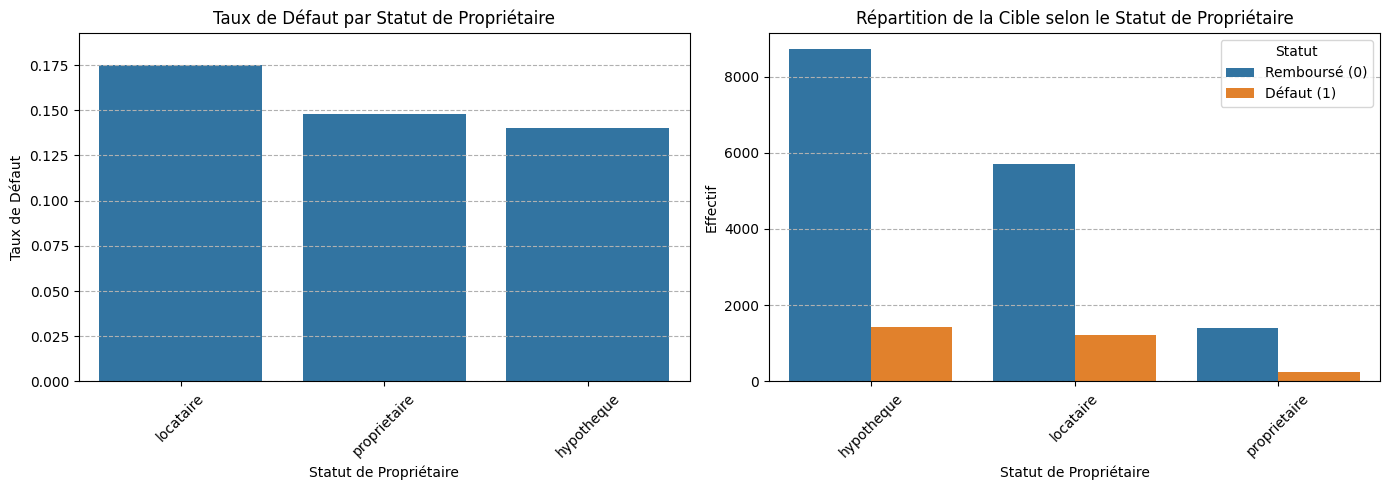


--- Test du Chi-Carré pour home_ownership ---
Statistique Chi2 : 39.96
P-value : 0.00000


In [ ]:
# Calcul du taux de défaut (moyenne de loan_status) par statut de propriétaire
defaut_rate_home = df.groupby('home_ownership')['loan_status'].mean().sort_values(ascending=False)

# Création de la figure combinée (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 (Taux de défaut par Statut)
sns.barplot(x=defaut_rate_home.index, y=defaut_rate_home.values, ax=axes[0])
axes[0].set_title('Taux de Défaut par Statut de propriétaire')
axes[0].set_xlabel('Statut de propriétaire')
axes[0].set_ylabel('Taux de défaut')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--')
axes[0].set_ylim(0, max(defaut_rate_home.values) * 1.1)

# Graphique 2 (Répartition de la cible)
sns.countplot(x='home_ownership', hue="loan_status", data=df, ax=axes[1])
axes[1].set_title("Répartition de la cible selon le Statut de propriétaire")
axes[1].set_xlabel('Statut de Propriétaire')
axes[1].set_ylabel('Effectif')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Statut', labels=['Remboursé (0)', 'Défaut (1)'])
axes[1].grid(axis='y', linestyle='--')

# Ajuster la mise en page
plt.tight_layout()
plt.show()

# Test Statistique : Test du Chi-2
contingency_table_home = pd.crosstab(df['home_ownership'], df['loan_status'])
chi2_home, p_value_home, dof_home, expected_home = chi2_contingency(contingency_table_home)

print(f"\n==== Test du Chi-2 pour home_ownership ====")
print(f"Statistique Chi2 : {chi2_home:.2f}")
print(f"P-value : {p_value_home:.5f}")

##### 7. Motif d'emprunt et statut du prêt

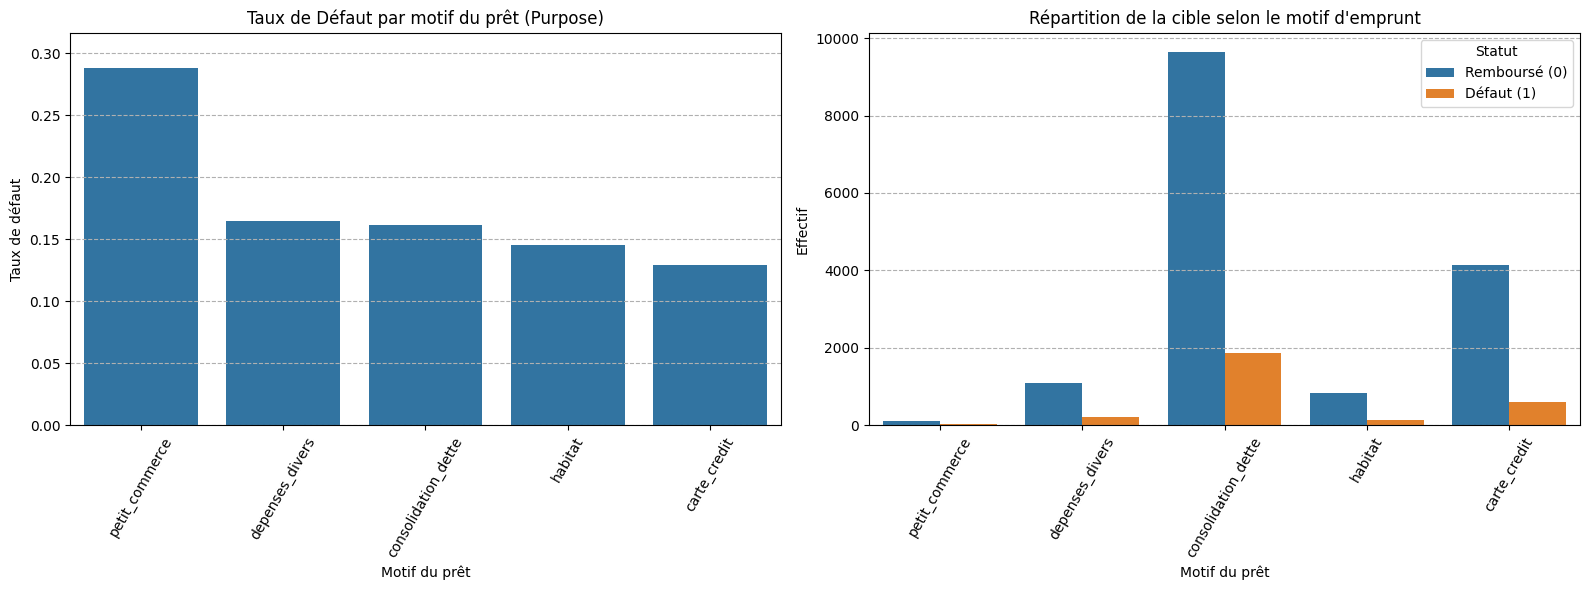


==== Test du Chi-Carré pour purpose ====
Statistique Chi2 : 49.25
P-value : 0.00000


In [ ]:
# Calcul du taux de défaut (moyenne de loan_status) par motif
defaut_rate_purpose = df.groupby('purpose')['loan_status'].mean().sort_values(ascending=False)

# Création de la figure combinée (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Taille plus grande car beaucoup de catégories

# Graphique 1 (Taux de Défaut par motif)
sns.barplot(x=defaut_rate_purpose.index, y=defaut_rate_purpose.values, ax=axes[0])
axes[0].set_title('Taux de Défaut par motif du prêt (Purpose)')
axes[0].set_xlabel('Motif du prêt')
axes[0].set_ylabel('Taux de défaut')
axes[0].tick_params(axis='x', rotation=60)
axes[0].grid(axis='y', linestyle='--')
axes[0].set_ylim(0, max(defaut_rate_purpose.values) * 1.1)

# Graphique 2 (Répartition de la Cible)
sns.countplot(x='purpose', hue="loan_status", data=df, order=defaut_rate_purpose.index, ax=axes[1])
axes[1].set_title("Répartition de la cible selon le motif d'emprunt")
axes[1].set_xlabel('Motif du prêt')
axes[1].set_ylabel('Effectif')
axes[1].tick_params(axis='x', rotation=60)
axes[1].legend(title='Statut', labels=['Remboursé (0)', 'Défaut (1)'])
axes[1].grid(axis='y', linestyle='--')

# Ajuster la mise en page
plt.tight_layout()
plt.show() 

# Test Statistique : Test du Chi-2
contingency_table_purpose = pd.crosstab(df['purpose'], df['loan_status'])
chi2_purpose, p_value_purpose, dof_purpose, expected_purpose = chi2_contingency(contingency_table_purpose)

print(f"\n==== Test du Chi-2 pour purpose ====")
print(f"Statistique Chi2 : {chi2_purpose:.2f}")
print(f"P-value : {p_value_purpose:.5f}")

#### 3.4. Corrélations entre variables quantitatives

In [223]:
# Extraction de variables quantitatives pour analyser la correlation
df_quanti=df[['loan_amnt','annual_inc','inq_last_6mths','avg_cur_bal',
                          'num_accts_ever_120_pd','pub_rec_bankruptcies','dti','pub_rec',
                          'chargeoff_within_12_mths','num_actv_bc_tl','int_rate','delinq_2yrs',
                          'acc_now_delinq','delinq_amnt','num_bc_sats']]



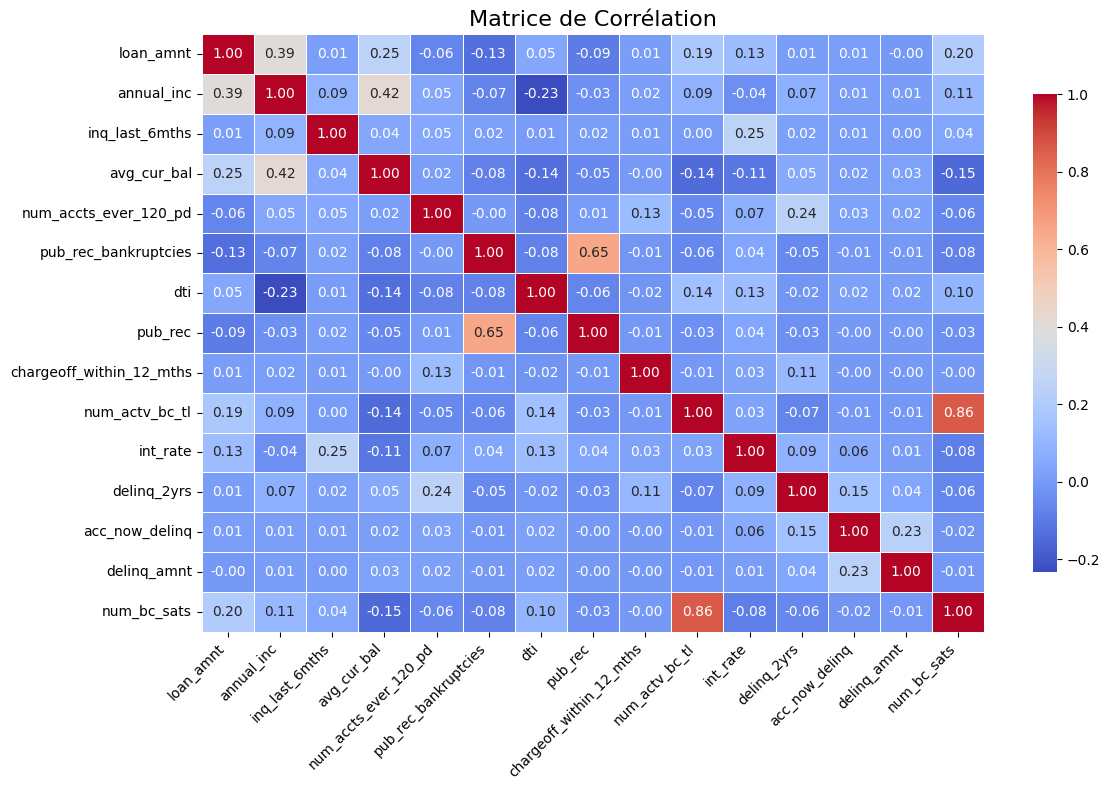

In [ ]:
# Matrice de corrélation
corr = df_quanti.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.8},
    linewidths=0.5
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Matrice de corrélation", fontsize=16)
plt.tight_layout()
plt.show()

### 4. Modélisation

Choix des variables pertinentes pour la modelisation

- **loan_status** : état de remboursement de la dette
- **loan_amnt** : montant du prêt. Plus le montant est élevé, plus le risque peut augmenter si revenu faible
- **term** : le nombre de paiement sur le prêt. prêts plus longs = plus de risque.
- **emp_length** : Categories selon le nombre d'années d'experience professionnelle
- **home_ownership** : le statut de propriétaire fourni par l'emprunteur lors de l'enregistrement
- **annual_inc** : Revenu annuel déclaré par l'emprunteur lors de l'inscription. Indicateur de capacité de remboursement
- **verification_status** : Indique si le revenu a été vérifié ou pas par Loan Club
- **purpose** : Raison de demande du prêt/finalité du prêt (conso, achat voiture, dette…). certaines finalités sont plus risquées.
- **dti** : Ratio calculé à partir du total des paiements mensuels de l'emprunteur sur l'ensemble de ses dettes, à l'exclusion de l'hypothèque et du pret LC demandé, divisé par les revenus mensuels déclarés par l'emprunteur. Il s'agit d'un indicateur direct de solvabilité.
- **delinq_2yrs** : Le nombre de cas d'impayés de plus de 30 jours figurant dans le dossier de crédit de l'emprunteur au cours des deux dernieres années. 
- **delinq_amnt** : Le montant dû sur les comptes surlequels l'emprunteur est en retard de paiement
- **pub_rec_bankruptcies** : nombre d’incidents publics (faillites, jugements),
- **num_accts_ever_120_pd**: Nombre de comptes en souffrance depuis 120 jours ou plus
- **chargeoff_within_12_mths** : Nombre d'impayés dans les 12 mois
- **avg_cur_bal** : Solde courant moyen de tous les comptes
- **acc_now_delinq** : Nombre de comptes pour lesquels l'emprunteur est en retard de paiement.

In [225]:
#Sélectionner les variables explicatives pertinentes (hors grade et int_rate)
df_mod=df[['loan_status','loan_amnt','term','emp_length',
'home_ownership','annual_inc','verification_status',
'purpose','dti','delinq_2yrs','delinq_amnt','pub_rec_bankruptcies','num_accts_ever_120_pd',
'chargeoff_within_12_mths','avg_cur_bal','acc_now_delinq']]

Découpage train (75%) / test (25%)

In [226]:
import sklearn
from sklearn.model_selection import train_test_split
X = df_mod.drop(columns=[ "loan_status"])  
y = df_mod["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
#grace à stratify=y la proportion des classes est la même dans train et test (important si la cible est déséquilibrée

Rééquilibrage des données

Le rééquilibrage est pertinent si ta variable cible est très déséquilibrée. Par exemple :

90% « Non » / 10% « Oui » → un modèle entraîné directement risque de toujours prédire la classe majoritaire.

Mais il ne faut jamais rééquilibrer avant de séparer les données !

Bon ordre :

>Séparer ton dataset en train / test (ou train / validation / test).
>Rééquilibrer uniquement le jeu d’entraînement.

Pourquoi ?
> Si tu rééquilibres tout le dataset avant le split, ton test set ne représentera plus la distribution réelle des classes → tu auras des métriques irréalistes.

Incovenient : 
SMOTE biaise la probabilité.

Autre choix:
Pondération de classe


Régression logistique (LogisticRegression de scikit-learn) sur differents modèles


Sans l'équilibration de notre série

In [ ]:
# Encoder les variables catégorielles dans X_train et X_test
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc = pd.get_dummies(X_test, drop_first=True)

# Harmoniser les colonnes (parfois certaines catégories n’existent que dans train ou test)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

#Les modalités fixées comme référence
for col in X_train.select_dtypes(include=['object']).columns:
    categories = sorted(X_train[col].dropna().unique())
    ref = categories[0]  # modalité supprimée si drop_first=True
    print(f"Variable : {col:25} → Référence = '{ref}'")

In [230]:
# Comparaison de 4 modèles logistiques 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
import numpy as np
import pandas as pd

# Définition des ensembles de variables

var_sets = {
    "Modèle 0 : Nul (constante seule)": [],

    "Modèle 1 : Financier simple": [
        'loan_amnt', 'annual_inc', 'dti'
    ],

    "Modèle 2 : + Socio-éco": [
        'loan_amnt', 'annual_inc', 'dti',
        'term', 'home_ownership', 'verification_status', 'emp_length', 'purpose'
    ],

    "Modèle 3 : Complet (finance + antécédents)": [
        'loan_amnt', 'annual_inc', 'dti',
        'term', 'purpose', 'home_ownership', 'verification_status', 'emp_length',
        'delinq_2yrs', 'delinq_amnt', 'pub_rec_bankruptcies',
        'num_accts_ever_120_pd', 'chargeoff_within_12_mths',
        'avg_cur_bal', 'acc_now_delinq'
    ]
}

results = []
roc_data = {}

# ============================================================
# 🔁 3. Boucle sur les modèles
# ============================================================

for name, vars in var_sets.items():
    print(f"\n🚀 Estimation du {name} ...")

    if vars == []:
        # --- Modèle nul : prédit la probabilité moyenne du train ---
        y_pred = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
        y_pred_class = np.where(y_pred >= 0.5, 1, 0)

    else:
        # --- Modèle logistique avec variables explicatives ---
        # Sélection automatique des variables pertinentes encodées
        X_train_sub = X_train_enc[[col for col in X_train_enc.columns if any(v in col for v in vars)]]
        X_test_sub  = X_test_enc[X_train_sub.columns]

        # Modèle pondéré pour corriger le déséquilibre sans SMOTE
        model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
        model.fit(X_train_sub, y_train)

        # Prédictions
        y_pred_class = model.predict(X_test_sub)
        y_pred = model.predict_proba(X_test_sub)[:, 1]

        # Données ROC pour visualisation
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_data[name] = (fpr, tpr, roc_auc_score(y_test, y_pred))

    # ============================================================
    # 📊 4. Calcul des métriques
    # ============================================================

    acc = accuracy_score(y_test, y_pred_class)
    rec = recall_score(y_test, y_pred_class)
    prec = precision_score(y_test, y_pred_class)
    auc = roc_auc_score(y_test, y_pred)

    results.append({
        'Modèle': name,
        'Accuracy': round(acc, 3),
        'Recall': round(rec, 3),
        'Precision': round(prec, 3),
        'AUC': round(auc, 3)
    })


🚀 Estimation du Modèle 0 : Nul (constante seule) ...

🚀 Estimation du Modèle 1 : Financier simple ...

🚀 Estimation du Modèle 2 : + Socio-éco ...

🚀 Estimation du Modèle 3 : Complet (finance + antécédents) ...


c:\Users\marln\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Comparaison des modèles

In [231]:
# Tableau comparatif des résultats sans équilibration de la série

results_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print("\nRésumé comparatif des modèles :")
display(results_df)


Résumé comparatif des modèles :


,Modèle,Accuracy,Recall,Precision,AUC
3,Modèle 3 : Complet (finance + antécédents),0.652,0.554,0.233,0.661
2,Modèle 2 : + Socio-éco,0.643,0.556,0.228,0.652
1,Modèle 1 : Financier simple,0.500,0.710,0.193,0.616
0,Modèle 0 : Nul (constante seule),0.846,0.000,0.000,0.500


Courbes de ROC

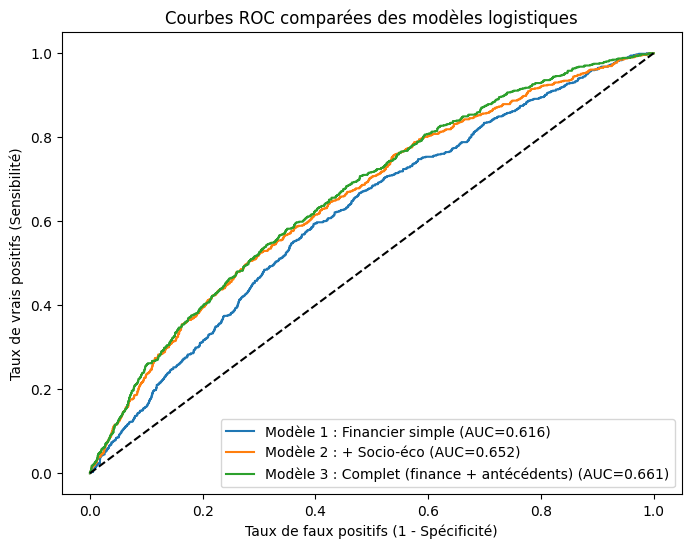

In [233]:
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("Courbes ROC comparées des modèles logistiques")
plt.xlabel("Taux de faux positifs (1 - Spécificité)")
plt.ylabel("Taux de vrais positifs (Sensibilité)")
plt.legend()
plt.show()


Sélection du meilleur modèle

In [234]:
best_model_name = results_df.loc[results_df['AUC'].idxmax(), 'Modèle']
print(f"Meilleur modèle selon l'AUC : {best_model_name}")

# Recalcule pour ce modèle
best_vars = var_sets[best_model_name]
best_cols = [col for col in X_train_enc.columns if any(v in col for v in best_vars)]
X_train_best = X_train_enc[best_cols]
X_test_best = X_test_enc[best_cols]

best_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
best_model.fit(X_train_best, y_train)

Meilleur modèle selon l'AUC : Modèle 3 : Complet (finance + antécédents)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'



Interprétation des coefficients (odds ratios)

In [235]:
coef_df = pd.DataFrame({
    'Variable': X_train_best.columns,
    'Coefficient': best_model.coef_[0]
})
coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Odds Ratio', ascending=False)

print("\nCoefficients et Odds Ratios du meilleur modèle :")
display(coef_df)


Coefficients et Odds Ratios du meilleur modèle :


,Variable,Coefficient,Odds Ratio
10,term_60,0.904799,2.471435
19,purpose_depenses_divers,0.105500,1.111266
14,home_ownership_locataire,0.101270,1.106575
21,purpose_petit_commerce,0.099028,1.104098
11,emp_length_jeune_diplome,0.092872,1.097321
17,verification_status_Verified,0.088444,1.092473
20,purpose_habitat,0.066733,1.069010
6,num_accts_ever_120_pd,0.025071,1.025388
3,delinq_2yrs,0.018563,1.018736
2,dti,0.017824,1.017984


Commentaire : 

### 5. Création du score

Calcul des probabilité sur l'ensemble test et calcul du score

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Prédiction des probabilités sur le jeu test
y_proba = best_model.predict_proba(X_test_best)[:, 1]  # probabilité prédite de défaut
df_scores = pd.DataFrame({'y_test': y_test, 'proba_defaut': y_proba})
df_scores['score_risque'] = (df_scores['proba_defaut'] * 100).round(2)

#Visualisation du tableau des scores et probabolités
display(df_scores)

,y_test,proba_defaut,score_risque
10170,0,0.571259,57.13
11240,0,0.275977,27.60
15518,0,0.459835,45.98
12474,0,0.459173,45.92
2297,1,0.461138,46.11
...,...,...,...
19520,0,0.431318,43.13
12157,0,0.394911,39.49
5549,1,0.608297,60.83
4292,0,0.534014,53.40


Visualisation de la distribution

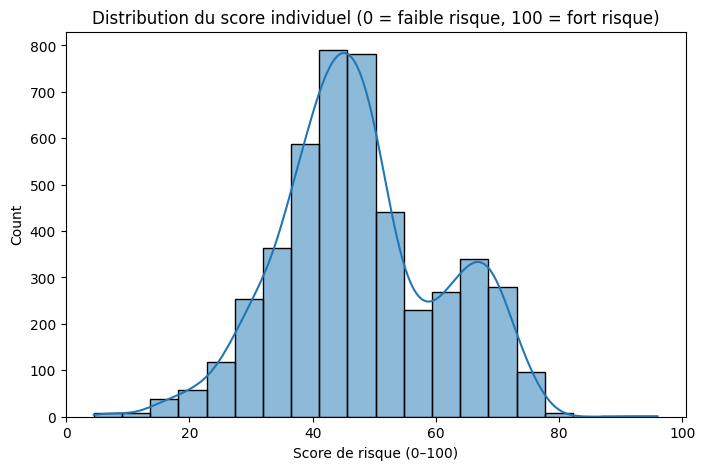

In [237]:
plt.figure(figsize=(8,5))
sns.histplot(df_scores['score_risque'], bins=20, kde=True)
plt.title("Distribution du score individuel (0 = faible risque, 100 = fort risque)")
plt.xlabel("Score de risque (0–100)")
plt.show()

Détermination du seuil optimal de classification par l'indice de Youden (J)

In [ ]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcul de l'indice de Youden (J = Sensibilité + Spécificité - 1)
youden_index = tpr - fpr
best_index = np.argmax(youden_index)
best_threshold = thresholds[best_index]

print(f" Seuil optimal (Youden) : {best_threshold:.3f}")
print(f" Sensibilité (Recall) : {tpr[best_index]:.3f}")
print(f" Spécificité : {1 - fpr[best_index]:.3f}")

 Seuil optimal (Youden) : 0.494
 Sensibilité (Recall) : 0.582
 Spécificité : 0.650


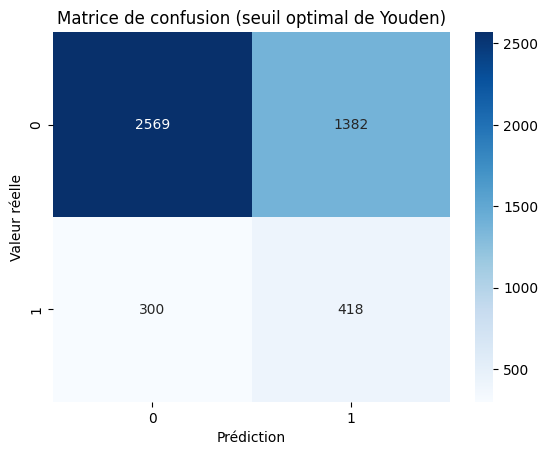


Rapport de classification :
              precision    recall  f1-score   support

           0       0.90      0.65      0.75      3951
           1       0.23      0.58      0.33       718

    accuracy                           0.64      4669
   macro avg       0.56      0.62      0.54      4669
weighted avg       0.79      0.64      0.69      4669



In [239]:
# Classification binaire selon le seuil optimal

df_scores['predicted_class'] = np.where(df_scores['proba_defaut'] >= best_threshold, 1, 0)

# Matrice de confusion
cm = confusion_matrix(df_scores['y_test'], df_scores['predicted_class'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion (seuil optimal de Youden)")
plt.xlabel("Prédiction")
plt.ylabel("Valeur réelle")
plt.show()

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(df_scores['y_test'], df_scores['predicted_class']))


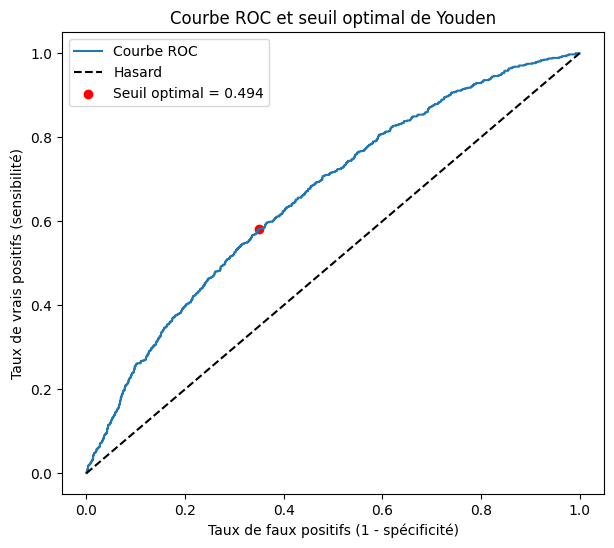

In [240]:
# Visualisation de la courbe ROC et du seuil optimal

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label='Courbe ROC')
plt.plot([0,1], [0,1], 'k--', label='Hasard')
plt.scatter(fpr[best_index], tpr[best_index], color='red',
            label=f'Seuil optimal = {best_threshold:.3f}')
plt.xlabel("Taux de faux positifs (1 - spécificité)")
plt.ylabel("Taux de vrais positifs (sensibilité)")
plt.title("Courbe ROC et seuil optimal de Youden")
plt.legend()
plt.show()


In [241]:
# Résumé final

print("\nRésumé du scoring :")
print(f"- Score individuel = probabilité * 100 (0 → risque faible, 100 → risque élevé)")
print(f"- Seuil optimal (Youden) = {best_threshold:.3f}")
print(f"- Score équivalent au seuil = {best_threshold*100:.1f}")
print(f"- Taux de vrais positifs (sensibilité) = {tpr[best_index]:.3f}")
print(f"- Taux de faux positifs = {fpr[best_index]:.3f}")


Résumé du scoring :
- Score individuel = probabilité * 100 (0 → risque faible, 100 → risque élevé)
- Seuil optimal (Youden) = 0.494
- Score équivalent au seuil = 49.4
- Taux de vrais positifs (sensibilité) = 0.582
- Taux de faux positifs = 0.350


### 6. Analyse par déciles

Découpage en 10 groupes selon le score

In [ ]:
# df_scores contient :
# - 'y_test' : vraie valeur (0 = bon payeur, 1 = défaut)
# - 'proba_defaut' : probabilité prédite
# - 'score_risque' : score (0 à 100)

# Création des déciles (1 à 10)
df_scores['decile'] = pd.qcut(df_scores['score_risque'], 10, labels=False, duplicates='drop') + 1

# Agrégation des résultats par décile
decile_summary = df_scores.groupby('decile').agg(
    effectif=('y_test', 'count'),
    score_moyen=('score_risque', 'mean'),
    proba_moyenne=('proba_defaut', 'mean'),
    taux_defaut=('y_test', 'mean')
).reset_index()

# Classement du plus faible au plus fort risque
decile_summary = decile_summary.sort_values(by='decile', ascending=True)

# Conversion du taux en pourcentage
decile_summary['taux_defaut(%)'] = (decile_summary['taux_defaut'] * 100).round(2)
decile_summary['proba_moyenne(%)'] = (decile_summary['proba_moyenne'] * 100).round(2)

# Arrondir les autres valeurs pour lisibilité
decile_summary['score_moyen'] = decile_summary['score_moyen'].round(2)

# Affichage final
print("Tableau de répartition du score en 10 groupes :")
display(decile_summary)


Tableau de répartition du score en 10 groupes :


,decile,effectif,score_moyen,proba_moyenne,taux_defaut,taux_defaut(%),proba_moyenne(%)
0,1,467,25.79,0.257911,0.044968,4.50,25.79
1,2,467,34.93,0.349258,0.081370,8.14,34.93
2,3,467,39.17,0.391715,0.098501,9.85,39.17
3,4,468,42.26,0.422607,0.119658,11.97,42.26
4,5,466,44.95,0.449541,0.128755,12.88,44.95
5,6,468,47.61,0.476051,0.149573,14.96,47.61
6,7,465,50.62,0.506169,0.174194,17.42,50.62
7,8,467,56.15,0.561457,0.186296,18.63,56.15
8,9,468,64.21,0.642086,0.230769,23.08,64.21
9,10,466,71.14,0.711414,0.324034,32.40,71.14


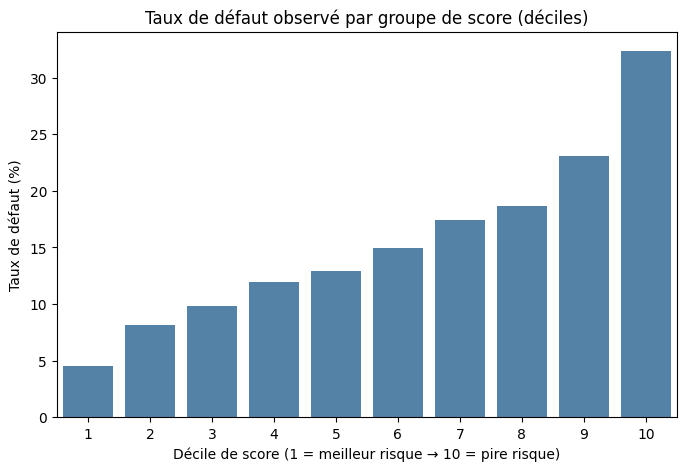

In [ ]:
# Visualisation : cohérence du modèle 

plt.figure(figsize=(8,5))
sns.barplot(data=decile_summary, x='decile', y='taux_defaut(%)', color='steelblue')
plt.title("Taux de défaut observé par groupe de score (déciles)")
plt.xlabel("Décile de score (1 = meilleur risque → 10 = pire risque)")
plt.ylabel("Taux de défaut (%)")
plt.show()


Visualisation combinée : cohérence prédiction et défaut réel

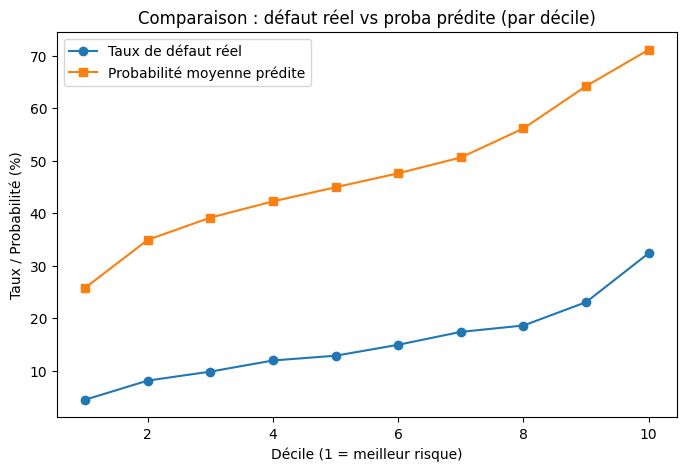

In [246]:
plt.figure(figsize=(8,5))
plt.plot(decile_summary['decile'], decile_summary['taux_defaut(%)'], marker='o', label='Taux de défaut réel')
plt.plot(decile_summary['decile'], decile_summary['proba_moyenne(%)'], marker='s', label='Probabilité moyenne prédite')
plt.title("Comparaison : défaut réel vs proba prédite (par décile)")
plt.xlabel("Décile (1 = meilleur risque)")
plt.ylabel("Taux / Probabilité (%)")
plt.legend()
plt.show()

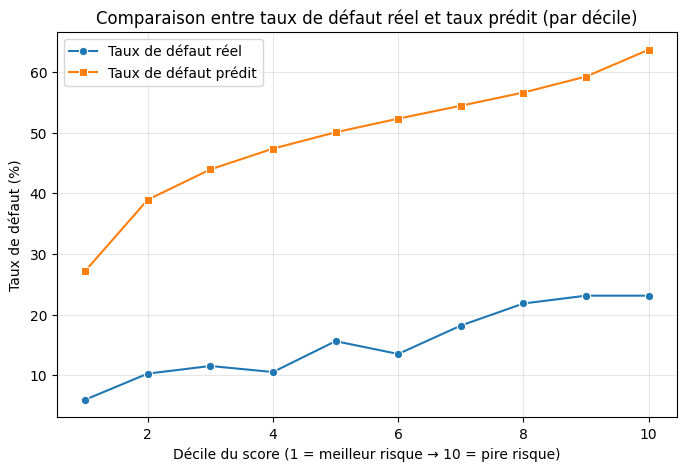

In [84]:
# ================================================
# 📊 Comparaison du taux réel vs taux prédit (par décile)
# ================================================

plt.figure(figsize=(8,5))

# Tracé du taux réel de défaut (observé)
sns.lineplot(
    data=decile_summary,
    x='decile',
    y='taux_defaut(%)',
    marker='o',
    label='Taux de défaut réel'
)

# Tracé du taux prédit (moyenne des proba)
sns.lineplot(
    data=decile_summary,
    x='decile',
    y='proba_moyenne(%)',
    marker='s',
    label='Taux de défaut prédit'
)

# Personnalisation du graphique
plt.title("Comparaison entre taux de défaut réel et taux prédit (par décile)")
plt.xlabel("Décile du score (1 = meilleur risque → 10 = pire risque)")
plt.ylabel("Taux de défaut (%)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
